## Figures

- Figure ST3 B,C

## Required files

- `models_dir / 'seq_model.pkl'` - chipseq model
- `rdir / 'src/chipnexus/train/seqmodel/ChIP-seq.dataspec.yml'`  -> chipseq raw files
- https://docs.google.com/spreadsheets/d/1PvHGy0P9_Yq0tZFw807bjadxaZHAYECE4RytlI9rdeQ/export?gid=0&format=csv replicate table
- `/srv/scratch/amr1/chip-seq-pipeline2/cromwell-executions/chip/{task}/call-bam2ta/shard-{rep_n -1}/execution/{task}.{strand}.bw` - raw output files

## Produced files

- Figure ST3 B
  - `{figures}/ll.pdf`
- Figure ST3 C
  - `{figures}/counts.pdf`

In [1]:
exp = 'seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE'
augment_train = True
augment_test = True
gpu = 0

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from basepair.imports import *
from basepair.plot.config import get_figsize, paper_config
from basepair.extractors import bw_extract
from matplotlib import ticker

# Use matplotlib paper config
paper_config()

Using TensorFlow backend.


In [3]:
from basepair.exp.paper.config import *

In [12]:
# Common paths
from basepair.config import get_data_dir, get_repo_root, test_chr, valid_chr
rdir = get_repo_root()
model_dir = models_dir / exp
figures = f"{ddir}/figures/model-evaluation/chipseq-bpnet/{exp}"

# Parameters
model_file = model_dir / "model.h5"

dataspec_file = rdir / "src/bpnet-pipeline/ChIP-seq.dataspec.yml"

history_file = model_dir / "history.csv"
seq_width = 1000
num_workers = 10

## Get predictions

In [13]:
import basepair
import pandas as pd
import numpy as np
from basepair.cli.schemas import DataSpec, TaskSpec
from pathlib import Path
from keras.models import load_model
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.losses import MultichannelMultinomialNLL
from basepair.plot.evaluate import regression_eval, plot_loss
from basepair.plot.utils import plt9_tilt_xlab
from basepair.cli.evaluate import eval_profile
from basepair import samplers 
from basepair.math import softmax

In [14]:
# !mv {model_dir}/preds.test.pkl {model_dir}/preds.test.bak.pkl

In [15]:
ds = DataSpec.load(dataspec_file)
tasks = list(ds.task_specs)

# Cache predictions
create_tf_session(gpu)
#bpnet = BPNetPredictor.from_mdir(model_dir)

In [16]:
from basepair.seqmodel import SeqModel
bpnet = SeqModel.from_mdir(model_dir)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2020-10-23 10:02:21,662 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2020-10-23 10:02:33,912 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [17]:
profile_bias_pool_size=[1,50]

In [18]:
from basepair.preproc import IntervalAugmentor
if augment_train:
    train_interval_transformer = IntervalAugmentor(max_shift=200, flip_strand=True) 
else:
    train_interval_transformer = lambda x: x
    
if augment_test:
    test_interval_transformer = IntervalAugmentor(max_shift=400, flip_strand=True) 
else:
    test_interval_transformer = lambda x: x

In [19]:
tasks = ['Oct4', 'Sox2', 'Nanog']

In [20]:
# if not os.path.exists(model_dir / "preds.test.pkl"):
    
model = bpnet.model
dl_test = StrandedProfile(ds, 
                          incl_chromosomes=test_chr, 
                          peak_width=seq_width,
                          shuffle=False,
                          target_transformer=AppendCounts(),
                          interval_transformer=test_interval_transformer,
                          profile_bias_pool_size=profile_bias_pool_size)

test = dl_test.load_all(num_workers=num_workers)
test_original = test  # Store for later
y_true = test["targets"]
y_pred = bpnet.predict(test['inputs'])
y_pred_seqonly = bpnet.predict(test['inputs']['seq'])
# write_pkl((test, y_pred), model_dir / "preds.test.pkl")

# Load predictions
# test, y_pred = read_pkl(model_dir / "preds.test.pkl")
# y_true = test['targets']

100%|██████████| 406/406 [00:06<00:00, 65.41it/s]


In [151]:
test_original['inputs'].keys()

dict_keys(['seq', 'bias/Oct4/profile', 'bias/Sox2/profile', 'bias/Nanog/profile', 'bias/Oct4/counts', 'bias/Sox2/counts', 'bias/Nanog/counts'])

In [21]:
# Load the training data and compute the average profile
dl_train = StrandedProfile(ds, 
                           excl_chromosomes=test_chr + valid_chr, 
                           peak_width=seq_width,
                           interval_transformer=train_interval_transformer,
                           shuffle=False)
train_data = dl_train.load_all(num_workers=num_workers)
avg_profile = {k.split("/")[1]: v.mean(axis=0) for k,v in train_data['targets'].items()}

100%|██████████| 1354/1354 [00:39<00:00, 34.39it/s] 


In [160]:
import scipy
# Performance of the bias track itself
print('PearsonR')
for task in tasks:
    print(task, scipy.stats.pearsonr(y_true[f'counts/{task}'].mean(axis=-1), test_original['inputs'][f'bias/{task}/counts'].mean(axis=-1))[0])

print('Spearmanr')
for task in tasks:
    print(task, scipy.stats.spearmanr(y_true[f'counts/{task}'].mean(axis=-1), test_original['inputs'][f'bias/{task}/counts'].mean(axis=-1))[0])

PearsonR
Oct4 0.19662052
Sox2 0.2415443
Nanog 0.056019947
Spearmanr
Oct4 0.1875088162557797
Sox2 0.24086999611265505
Nanog 0.04503150229668705


## Predicted vs observed scatterplot of log10(counts + 1)

In [22]:
def regression_eval(y_true, y_pred, alpha=0.5, markersize=2, task="", ax=None, same_lim=False, loglog=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    from scipy.stats import pearsonr, spearmanr
    xmax = max([y_true.max(), y_pred.max()])
    xmin = min([y_true.min(), y_pred.min()])
    
    if loglog:
        pearson, pearson_pval = pearsonr(np.log10(y_true), np.log10(y_pred))
        spearman, spearman_pval = spearmanr(np.log10(y_true), np.log(y_pred))
    else:
        pearson, pearson_pval = pearsonr(y_true, y_pred)
        spearman, spearman_pval = spearmanr(y_true, y_pred)
    if loglog:
        plt_fn = ax.loglog
    else:
        plt_fn = ax.plot
        
    plt_fn(y_pred, y_true, ".", 
           markersize=markersize, 
           rasterized=True,
           alpha=alpha)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Observed")
    
    if same_lim:
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((xmin, xmax))
    rp = r"$R_{p}$"
    rs = r"$R_{s}$"
    ax.set_title(task)
    ax.text(.95, .2, f"{rp}={pearson:.2f}",
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes)
    ax.text(.95, .05, f"{rs}={spearman:.2f}", 
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes)

## Scatterplots

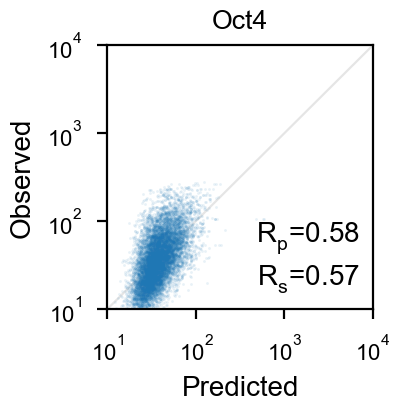

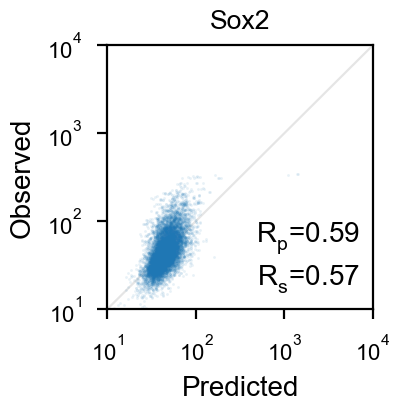

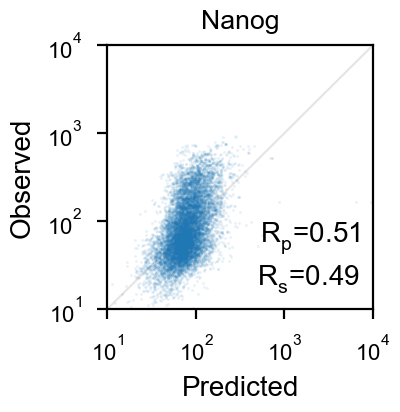

In [15]:
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

for task in tasks:
    fig, ax= plt.subplots(figsize=get_figsize(frac=0.25, aspect=1))
    yt = np.exp(y_true[f'counts/{task}'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    plt.minorticks_off()
    # save the figure
    os.makedirs(f"{figures}/scatter", exist_ok=True)
    fig.savefig(f"{figures}/scatter/{task}.pdf")
    fig.savefig(f"{figures}/scatter/{task}.png")

### All plots in one row

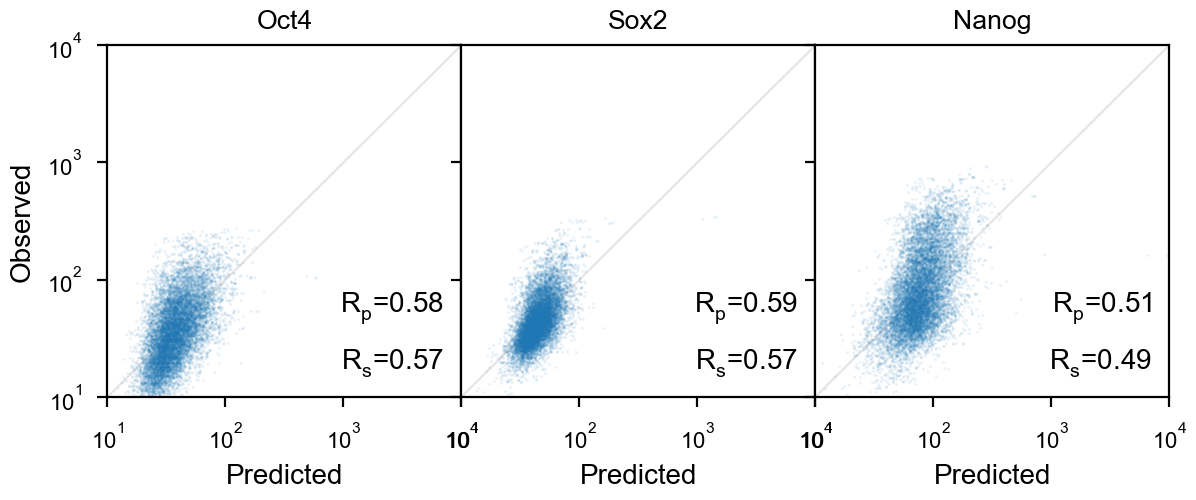

In [16]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'counts/{task}'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()
# Save the figure
fig.savefig(f"{figures}/scatter/all.pdf")
fig.savefig(f"{figures}/scatter/all.png")

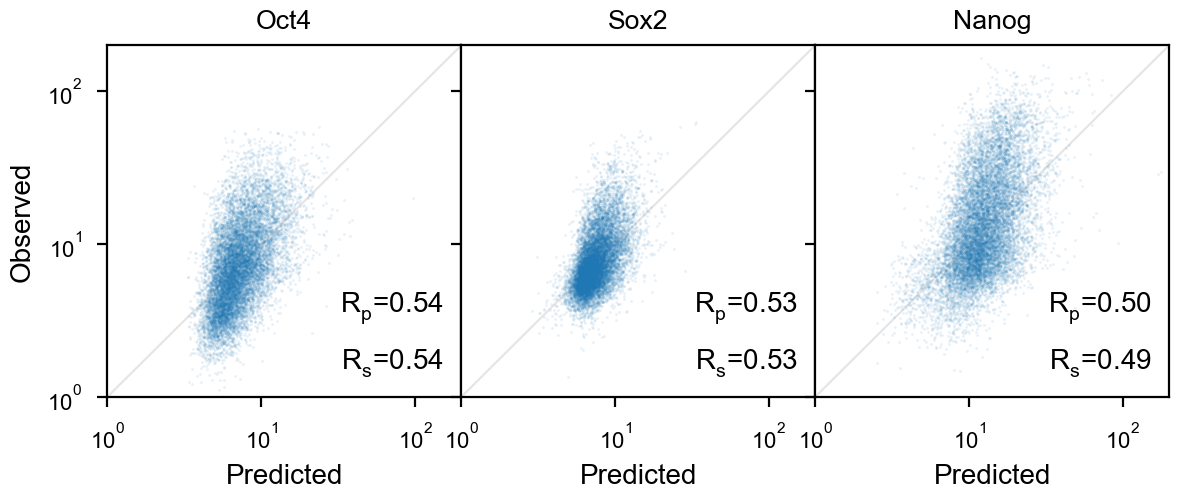

In [507]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    
    yp_all = y_pred[f'{task}/counts'].mean(-1)
    yp_bias = yp_all - y_pred_seqonly[f'{task}/counts'].mean(-1)
    yt = np.exp(y_true[f'counts/{task}'].mean(-1) - yp_bias)
    yp = np.exp(y_pred_seqonly[f'{task}/counts'].mean(-1))
    xrange = [1, 2e2]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()
# Save the figure
fig.savefig(f"{figures}/scatter/all-bias-corrected.pdf", raster=True)

## Profile plots (predicted vs observed)

- for each set of TF peaks (all non-overlapping) in the test set (chr1, chr8, chr9), choose two with most counts

In [23]:
from basepair.plot.profiles import plot_profiles
from basepair import samplers
from kipoi.data_utils import get_dataset_item
from kipoi.metadata import GenomicRanges
import pybedtools
from basepair.utils import flatten_list
from basepair.plot.tracks import plot_tracks, filter_tracks
from basepair.preproc import dfint_no_intersection
from pybedtools import BedTool

In [24]:
# Figure out valid indices (non-overlapping)
df_ranges = pd.DataFrame(test['metadata']['range'])[['chr', 'start','end']]
df_ranges_tasks = {t: df_ranges[test['metadata']['interval_from_task'] == t] for t in bpnet.tasks}
all_intervals = list(BedTool.from_dataframe(df_ranges))

o = dict()
for i,t in enumerate(bpnet.tasks):
    dft = df_ranges.iloc[test['metadata']['interval_from_task'] == t]
    if i == 0:
        o[t] = dft
    else:
        df_existing = pd.concat(list(o.values()), axis=0)
        o[t] = dft[dfint_no_intersection(dft, df_existing)]
valid_idx = pd.concat(list(o.values()), axis=0).index

valid_idx_bool = pd.Series(np.arange(len(df_ranges))).isin(valid_idx)

print("Fraction of non-overlapping peaks:", valid_idx_bool.mean())

Fraction of non-overlapping peaks: 0.6646646646646647


In [25]:
from genomelake.extractors import FastaExtractor
from basepair.preproc import resize_interval

In [26]:
input_seqlen = 1000 - bpnet.body.get_len_change()  - bpnet.heads[0].net.get_len_change()

In [27]:
yt = sum([y_true[f'profile/{task}']
          for task in tasks])

In [28]:
(yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2)).max()

0.09090909

In [29]:
max_frac = (yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2))

In [30]:
max_pos = (yt ).max(axis=(-1, -2))
total_counts = (yt ).sum(axis=(-1, -2))

## Smoothing

### Replicate task specs

In [31]:
rep_indices = [f'C{x:02d}' for x in np.arange(1, 8)]

In [32]:
reps = pd.read_csv("https://docs.google.com/spreadsheets/d/1PvHGy0P9_Yq0tZFw807bjadxaZHAYECE4RytlI9rdeQ/export?gid=0&format=csv")

In [33]:
reps = reps[reps.Mnemonic.isin(rep_indices)]

In [34]:
reps.head()

,Mnemonic,FTP Name,thenexus Name,Sample ID,Comments,Reference,Data Type,TF Name,Rep Number,Control Reps,QC report,Unique deduped reads,Held-out test,"#Rep-IDRpeaks (N1, N2, ..)",#IDR-optimal peaks (Np),Md5-hash-FASTQ,Md5-hash-IDRoptimal,Md5-bigwigs,idr_frip_qc/ppr/FRiP,idr_reproducibility_qc/rescue_ratio,Oak path bw neg
0,C01,mesc_oct4_chipseq_1,m_esc_1m_oct4_chipseq...,2222.0,NaN,mm10,chipseq,oct4,1.0,"C14,C15",http://mitra.stanford...,27M,False,10770.0,19351.0,ca231a170bad4679ace07...,NaN,NaN,NaN,NaN,NaN
1,C02,mesc_oct4_chipseq_2,chipseq_mesc_10m_oct4_2,2383.0,NaN,mm10,chipseq,oct4,2.0,"C14,C15",http://mitra.stanford...,18M,True,14402.0,19351.0,61280040ed745ef31c228...,NaN,NaN,NaN,NaN,NaN
2,C03,mesc_sox2_chipseq_1,m_esc_1m_sox2_chipseq...,2223.0,NaN,mm10,chipseq,sox2,1.0,"C14,C15",http://mitra.stanford...,19M,False,255.0,9497.0,1d4228d99a87618c8813e...,NaN,NaN,NaN,NaN,NaN
3,C04,mesc_sox2_chipseq_2,mesc_sox2_chipseq_2,3659.0,NaN,mm10,chipseq,sox2,2.0,"C14,C15",http://mitra.stanford...,49M,False,8847.0,9497.0,28bf183b8c906280844e8...,NaN,NaN,NaN,NaN,NaN
4,C05,mesc_sox2_chipseq_3,m_esc_10m_sox2_chipse...,2224.0,NaN,mm10,chipseq,sox2,3.0,"C14,C15",http://mitra.stanford...,32M,True,4202.0,9497.0,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
from basepair.cli.schemas import TaskSpec

In [36]:
from glob import glob
def get_bigwig(row, strand):
    rep_n = int(row['Rep Number'])
    task = row['TF Name'].capitalize()
    rep_name = row['FTP Name'].split(".")[0]
    # base_path = '/srv/scratch/amr1/chip-seq-pipeline2/cromwell-executions/chip'
    base_path = '/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq'
    glob_path = f"{base_path}/{task}/call-count_signal_track/shard-{rep_n -1}/glob-*/*.{strand}.bigwig"
    paths = glob(glob_path)
    if len(paths) == 1:
        return paths[0]
    elif len(paths) > 1:
        raise ValueError(f'Multiple Paths: {paths}')
    else:
        raise ValueError(f'Path doesnt exist with glob: {glob_path}')
    return f"{base_path}/{task}/call-bam2ta/shard-{rep_n -1}/execution/{task}.{strand}.bw"

def get_taskspec(rows):
    task = rows.iloc[0]['TF Name'].capitalize()
    pos_counts=[get_bigwig(rows.iloc[i], 'positive') for i in range(len(rows))]
    neg_counts=[get_bigwig(rows.iloc[i], 'negative') for i in range(len(rows))]
    return TaskSpec(task=task, pos_counts=pos_counts, neg_counts=neg_counts)

In [37]:
from pathlib import Path

In [38]:
base_path = Path('/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq')

In [39]:
# Exclude one Sox2 rep
reps = reps[reps.Mnemonic != 'C03']
reps.loc[reps['TF Name'] == 'sox2', 'Rep Number'] = [1,2]

In [40]:
dataspec_train = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == False)])
                                                 for task in tasks},
                  fasta_file="")

In [41]:
dataspec_test = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == True)])
                                                 for task in tasks},
                  fasta_file="")

In [42]:
dataspec_train.touch_all_files()
dataspec_test.touch_all_files()

## Compute the same stats for the technical replicates

- always have two technical replicates for each factor

In [43]:
# Augment the intervals
# test_interval_transformer = IntervalAugmentor(max_shift=600, flip_strand=True) 
shifted_intervals = [test_interval_transformer(interval) for interval in all_intervals]

In [44]:
!ls /oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/*

/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/bam2ta-0.log
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/gcs_delocalization.sh
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/gcs_localization.sh
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/gcs_transfer.sh
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/glob-199637d3015dccbe277f621a18be9eb4.list
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/memory_retry_rc
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/monitoring.log
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/rc
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/script
/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-bam2ta/shard-0/stder

In [45]:
dataspec_train.task_specs['Oct4'].pos_counts

['/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/Oct4/call-count_signal_track/shard-0/glob-079074fef208d29e859788ed8db804b6/mesc_oct4_chipseq_rep1.merged.nodup.positive.bigwig']

In [46]:
os.path.exists('/oak/stanford/groups/akundaje/amr1/bpnet/processed_chipseq/oct4/call-count_signal_track/shard-0/execution/mesc_oct4_chipseq_1.trim.merged.nodup.positive.bigwig')

False

In [47]:
train = dataspec_train.load_counts(shifted_intervals, progbar=True)
test = dataspec_test.load_counts(shifted_intervals, progbar=True)

100%|██████████| 12987/12987 [00:02<00:00, 5803.75it/s]


In [48]:
ds.touch_all_files()

In [ ]:
# TODO - compare the intervals

In [49]:
bias = ds.load_bias_counts(shifted_intervals)

In [50]:
seqs = FastaExtractor(fasta_file, use_strand=True)(shifted_intervals)

In [51]:
y_pred = bpnet.predict(seqs)

### Evaluate

In [52]:
from basepair.cli.evaluate import bin_counts_summary
from basepair.losses import multinomial_nll as k_multinomial_nll
from basepair.exp.paper.config import peak_pred_metric
from basepair.metrics import *
import keras.backend as K
import tensorflow as tf
from basepair.stats import symmetric_kl
import matplotlib.pyplot as plt
from basepair.preproc import moving_average
import random

class BinnedMetric:
    def __init__(self, metric, binsizes):
        self.metric = metric
        self.binsizes= binsizes

    def __call__(self, y_true, y_pred):
        return [{"binsize": binsize, **self.metric(
            bin_counts_summary(y_true, binsize=binsize, fn=np.sum),
            bin_counts_summary(y_pred, binsize=binsize, fn=np.sum))}
                for binsize in self.binsizes]

def normalize(x):
    p = x / np.maximum(np.sum(x, axis=-1, keepdims=True), 1e-8)
    p += 1 / (x.shape[-1]*10)  # Should be 
    p = p / np.sum(p, axis=-1, keepdims=True)
    return p

# Override the binsizes for peak_pred_metric
def multinomial_nll(y_true, y_pred):
    from scipy.stats import multinomial
    # subset = y_true.sum(axis=-1) > 0
    subset = slice(None)
    return -multinomial.logpmf(x=y_true[subset],
                               n=y_true[subset].sum(axis=-1), 
                               p=normalize(y_pred[subset]))

def stranded_multinomial_nll(y_true, y_pred):
    return (np.nanmean(multinomial_nll(y_true[:, :, 0], y_pred[:, :, 0])) +
            np.nanmean(multinomial_nll(y_true[:, :, 1], y_pred[:, :, 1])))

def padded_symmetric_kl(y_true, y_pred):
    return (symmetric_kl(normalize(moving_average(y_true[:, :, 0], n=50)), normalize(y_pred[:, :, 0])) +
            symmetric_kl(normalize(moving_average(y_true[:, :, 1], n=50)), normalize(y_pred[:, :, 1])))

In [53]:
binsizes = [1, 2, 5, 10, 20, 50]  # 2, 5, 
peak_pred_metric.binsizes = binsizes

metric = BPNetMetricSingleProfile(
    count_metric=pearson_spearman,
    profile_metric=stranded_multinomial_nll
)

In [54]:
binned_metrics = BinnedMetric(metric, binsizes)

In [55]:
# TODO(avsec): Evaluate input control for the metrics...

In [56]:
train_reps = {}
for task in tasks:
    train_reps[task] = np.array([moving_average(train[task][i], n=50) for i in range(len(train[task]))])

In [57]:
bias_smoothed = {}
for task in tqdm(tasks):
    bias_smoothed[task] = np.array([moving_average(bias['input'][i], n=50) for i in range(len(bias['input']))])

100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


In [161]:
# Residual from the bias prediction.
y_pred_bias = {}
for k in y_pred:
    y_pred_bias[k] = y_pred[k] - y_pred_seqonly[k]

In [58]:
metrics = {task: binned_metrics(test[task], train_reps[task]) for task in tqdm(tasks)}

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


In [59]:
metrics_bias = {task: binned_metrics(test[task], bias_smoothed[task]) for task in tqdm(tasks)}

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


In [60]:
# y_pred only used sequences to make predictions (i.e. no bias track)
metrics_model = {task: binned_metrics(test[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.62s/it]


In [62]:
metrics_avg = {task: binned_metrics(test[task], 
                                    np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
               for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.51s/it]


In [63]:
metrics_const = {task: binned_metrics(test[task], 
                                    np.repeat(np.ones_like(avg_profile[task][np.newaxis]), len(test[task]), axis=0)) 
               for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.45s/it]


In [64]:
def profile_metrics2df(m, norm=None):
    out = []
    for task,v in m.items():
        for bin_id in range(len(v)):
            if norm is None:
                profile = v[bin_id]['profile']
            else:
                profile = v[bin_id]['profile'] - norm[task][bin_id]['profile']
            out.append({"task": task,
                        "binsize": v[bin_id]['binsize'],
                        "profile": profile
                       })
    return pd.DataFrame(out)


def count_metrics2df(m):
    out = []
    for task,v in m.items():
        out.append({"task": task,
                    "pearsonr": v[0]['counts']['pearsonr']
                       })
    return pd.DataFrame(out)

In [207]:
dfm_profile = profile_metrics2df(metrics, metrics_const).assign(method='Replicates')
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_model, metrics_const).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_avg, metrics_const).assign(method='Average')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_bias, metrics_const).assign(method='Input control')])

dfm_counts = count_metrics2df(metrics).assign(method='Replicates')
dfm_counts = pd.concat([dfm_counts, count_metrics2df(metrics_model).assign(method='BPNet')])
dfm_counts = pd.concat([dfm_counts, count_metrics2df(metrics_bias).assign(method='Input control')])

In [208]:
dfm_profile['split'] = 'train->test'
dfm_profile1 = dfm_profile.copy()
dfm_counts['split'] = 'train->test'
dfm_counts1 = dfm_counts.copy()

In [125]:
# Swap train and test

In [68]:
test_reps = {}
for task in tasks:
    test_reps[task] = np.array([moving_average(test[task][i], n=50) for i in range(len(test[task]))])
    
shuff_metrics = {task: binned_metrics(train[task], test_reps[task]) for task in tqdm(tasks)}

100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


In [69]:
shuff_metrics_bias = {task: binned_metrics(train[task], bias_smoothed[task]) for task in tqdm(tasks)}

100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


In [70]:
shuff_metrics_model = {task: binned_metrics(train[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) 
                       for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.66s/it]


In [72]:
shuff_metrics_avg = {task: binned_metrics(train[task],
                                          np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
                     for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.57s/it]


In [73]:
shuff_metrics_const = {task: binned_metrics(train[task],
                                          np.repeat(np.zeros_like(avg_profile[task][np.newaxis]), len(test[task]), axis=0)) 
                     for task in tqdm(tasks)}

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


In [209]:
dfm_profile = profile_metrics2df(shuff_metrics, shuff_metrics_const).assign(method='Replicates')
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(shuff_metrics_model, shuff_metrics_const).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(shuff_metrics_avg, shuff_metrics_const).assign(method='Average')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(shuff_metrics_bias, shuff_metrics_const).assign(method='Input control')])

dfm_counts = count_metrics2df(shuff_metrics).assign(method='Replicates')
dfm_counts = pd.concat([dfm_counts, count_metrics2df(shuff_metrics_model).assign(method='BPNet')])
dfm_counts = pd.concat([dfm_counts, count_metrics2df(shuff_metrics_bias).assign(method='Input control')])

In [210]:
dfm_profile['split'] = 'test->train'
dfm_profile2 = dfm_profile.copy()
dfm_counts['split'] = 'test->train'
dfm_counts2 = dfm_counts.copy()

In [211]:
df_nll_tidy = pd.concat([dfm_profile1, dfm_profile2])
df_nll_tidy['method'] = pd.Categorical(df_nll_tidy['method'], categories=["BPNet", "Replicates", "Input control", "Average"])
df_nll_tidy['task'] = pd.Categorical(df_nll_tidy['task'], categories=tasks)

df_nll_tidy = df_nll_tidy[df_nll_tidy.binsize < 100]
df_nll_tidy['profile_ll'] = -df_nll_tidy['profile']

In [212]:
df_counts_tidy = pd.concat([dfm_counts1, dfm_counts2])
df_counts_tidy['method'] = pd.Categorical(df_counts_tidy['method'],
                                          categories=["BPNet", "Replicates", "Input control", ])
df_counts_tidy['task'] = pd.Categorical(df_counts_tidy['task'], categories=tasks)

Plot

In [213]:
from plotnine import *
import plotnine

plotnine.__version__

'0.5.1'

In [214]:
paper_config()

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3.42519 x 1.027557 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /users/avsec/workspace/bpnet-manuscript/data/figures/model-evaluation/chipseq-bpnet/seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE/ll.v2.with-input-control.pdf
  warn('Filename: {}'.format(filename))


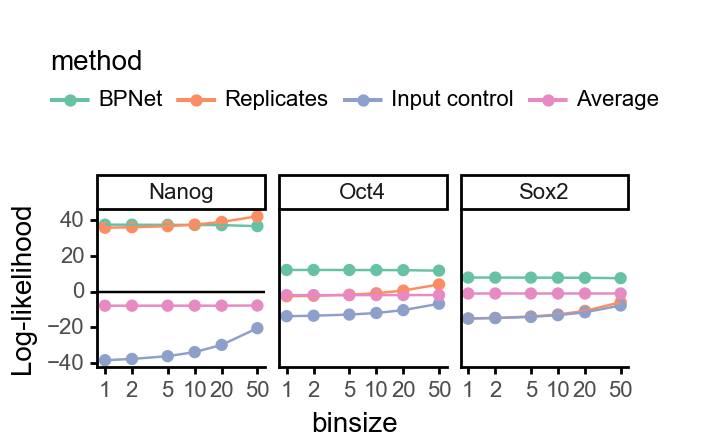

<ggplot: (8728431112726)>

In [215]:
# Reproduce plot
plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
_df = df_nll_tidy.groupby(['binsize', 'task', 'method']).profile_ll.mean().reset_index()
_df['task'] = _df['task'].cat.reorder_categories(tasks)

fig = ggplot(aes(x='binsize', y='profile_ll', color='method'), data=_df) + \
  scale_x_log10(breaks=binsizes) + \
  geom_point() + \
  geom_line() + \
  geom_abline(intercept=0, slope=0) + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  facet_grid(". ~ task") + \
  scale_color_brewer('qual', 7) + \
  ylab("Log-likelihood")
fig.save(f"{figures}/ll.v2.with-input-control.pdf")
fig

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 3.42519 x 1.027557 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /users/avsec/workspace/bpnet-manuscript/data/figures/model-evaluation/chipseq-bpnet/seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE/ll.v2.pdf
  warn('Filename: {}'.format(filename))


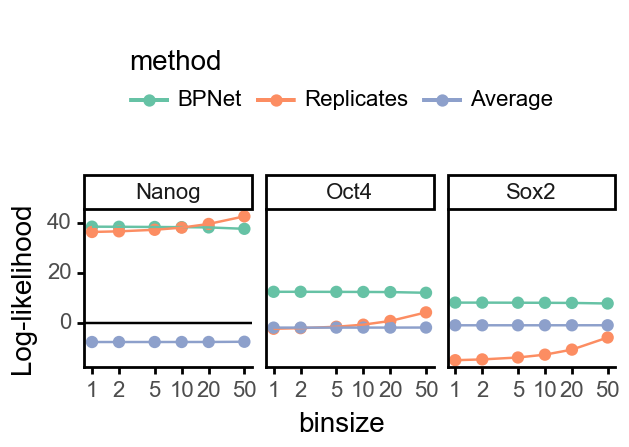

<ggplot: (8739826378374)>

In [140]:
# Reproduce plot
plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
fig = ggplot(aes(x='binsize', y='profile_ll', color='method'), data=df_nll_tidy.groupby(['binsize', 'task', 'method']).profile_ll.mean().reset_index()) + \
  scale_x_log10(breaks=binsizes) + \
  geom_point() + \
  geom_line() + \
  geom_abline(intercept=0, slope=0) + \
  facet_grid(".~task") + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  scale_color_brewer('qual', 7) + \
  ylab("Log-likelihood")
fig.save(f"{figures}/ll.v2.pdf")
fig

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 4.795266 x 1.4385797999999999 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /users/avsec/workspace/bpnet-manuscript/data/figures/model-evaluation/chipseq-bpnet/seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE/counts-with-input-control.pdf
  warn('Filename: {}'.format(filename))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:80: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:80: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the gro

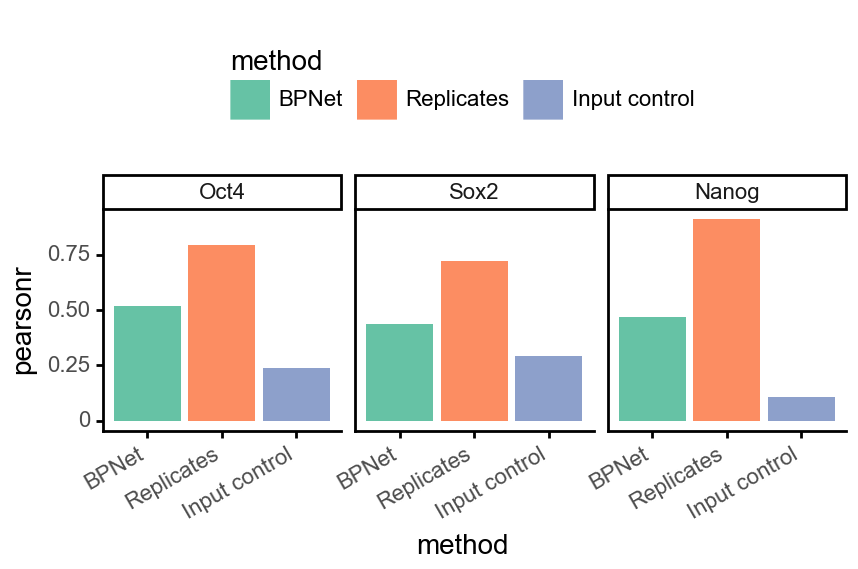

<ggplot: (-9223363308425486087)>

In [216]:
plotnine.options.figure_size = get_figsize(0.7, aspect=0.3)
fig = ggplot(aes(x='method', y='pearsonr', fill='method'), data=df_counts_tidy.groupby(['task', 'method']).pearsonr.mean().reset_index()) + \
  geom_bar(stat='identity', position='dodge') + \
  geom_line() + \
  facet_grid(".~task") + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  scale_fill_brewer('qual', 7) + \
  plt9_tilt_xlab(30)
fig.save(f"{figures}/counts-with-input-control.pdf")
fig

In [112]:
viz_dict = flatten_list([[
    ("Obs bias", bias['input'][i]),
    ("Obs 1", train[TF][i]),
    ("Obs 3", test[TF][i]),
    # "avg": avg_profile[task],
    ("pred", y_pred[f'{TF}/profile'][i]),
            ] for TF in tasks])
